# Text Embeddings and Vector Search with Weaviate

## Yale AI Research Techniques Workshop
### July 2, 2025

In this notebook, we'll explore:
- How text embeddings encode semantic meaning
- Building a vector database with Weaviate
- Applying embeddings to entity resolution in library catalogs
- Visualizing semantic relationships in vector space

## 1. Setup and Installation

First, let's install the required packages and set up our environment.

In [ ]:
# Install required packages
!pip install -q weaviate-client openai numpy pandas matplotlib seaborn scikit-learn plotly

In [19]:
# Import necessary libraries
import os
import json
import hashlib
import numpy as np
import pandas as pd
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

# Weaviate and OpenAI imports
import weaviate
from weaviate.classes.config import Configure, Property, DataType, VectorDistances
from weaviate.classes.query import Filter, MetadataQuery
from weaviate.util import generate_uuid5
from openai import OpenAI

# Set visual style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [20]:
# Set up API keys (you'll need to add your own)
#from google.colab import userdata

# Get OpenAI API key from Colab secrets
#os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

# Initialize OpenAI client
openai_client = OpenAI(api_key=os.environ['OPENAI_API_KEY'])

## 2. Understanding Text Embeddings

Text embeddings are numerical representations of text that capture semantic meaning. Words or phrases with similar meanings have similar vector representations.

In [21]:
# Let's create embeddings for some simple examples
def get_embedding(text: str) -> np.ndarray:
    """Get embedding for a single text using OpenAI's API."""
    response = openai_client.embeddings.create(
        model="text-embedding-3-small",
        input=text
    )
    return np.array(response.data[0].embedding)

# Example texts - individual field values
field_examples = [
    ("Schubert, Franz, 1797-1828", "person"),
    ("Schubert, Franz August, 1805-1893", "person"),
    ("Mozart, Wolfgang Amadeus, 1756-1791", "person"),
    ("Photography in archaeology", "subjects"),
    ("Fotografía en arqueología", "subjects"),
    ("Fotografia em arqueologia", "subjects"),
    ("Archäologie und Photographie: fünfzig Beispiele zur Geschichte und Methode", "title")
]

# Generate embeddings
embeddings = {}
for text, field_type in field_examples:
    embeddings[text] = get_embedding(text)
    print(f"✓ Generated embedding for {field_type}: {text[:50]}...")
    print(f"  Embedding shape: {embeddings[text].shape}")
    print(f"  First 5 values: {embeddings[text][:5]}\n")

✓ Generated embedding for person: Schubert, Franz, 1797-1828...
  Embedding shape: (1536,)
  First 5 values: [-0.05884523 -0.06004278  0.00864612  0.00274869  0.02599514]

✓ Generated embedding for person: Schubert, Franz August, 1805-1893...
  Embedding shape: (1536,)
  First 5 values: [-0.04930551 -0.05913316  0.00303193  0.01208591  0.02925293]

✓ Generated embedding for person: Mozart, Wolfgang Amadeus, 1756-1791...
  Embedding shape: (1536,)
  First 5 values: [-0.01378832 -0.01859163  0.01254511  0.03422217  0.00568203]

✓ Generated embedding for subjects: Photography in archaeology...
  Embedding shape: (1536,)
  First 5 values: [ 0.01174796  0.00791082 -0.01537484 -0.00876497 -0.04696554]

✓ Generated embedding for subjects: Fotografía en arqueología...
  Embedding shape: (1536,)
  First 5 values: [ 0.00390061  0.00691184 -0.02545139  0.00825139 -0.05257172]

✓ Generated embedding for subjects: Fotografia em arqueologia...
  Embedding shape: (1536,)
  First 5 values: [-0.0003672

## 3. Measuring Semantic Similarity

We use cosine similarity to measure how similar two embeddings are. Values range from -1 (opposite) to 1 (identical).

Cosine Similarity Matrix:



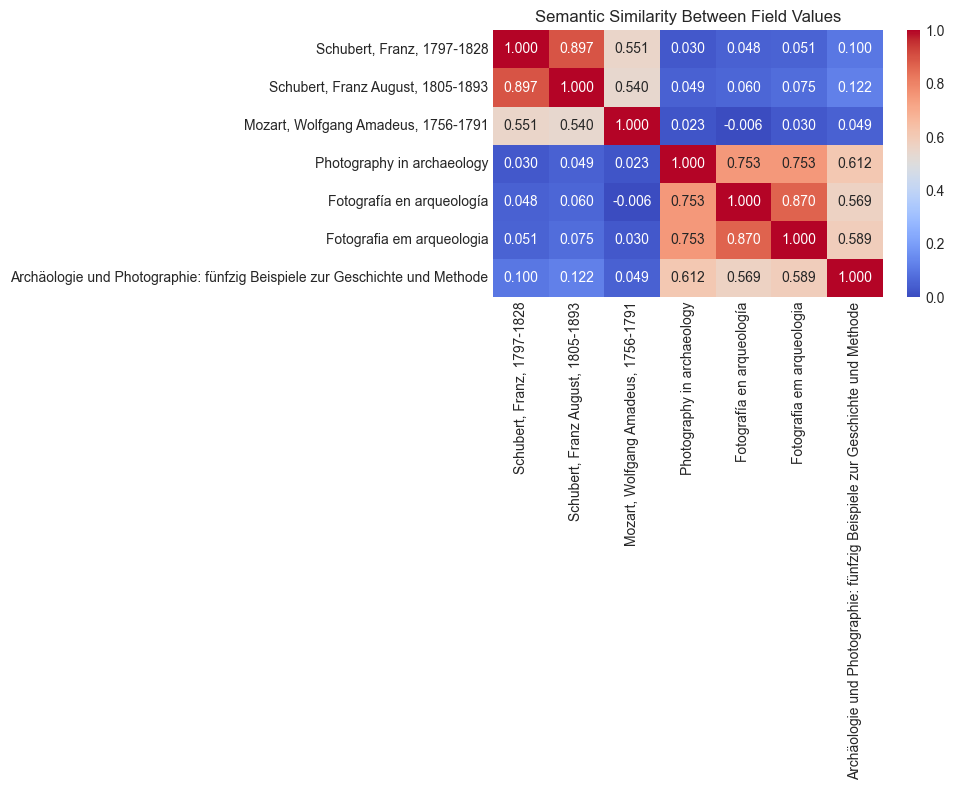

In [22]:
# Calculate cosine similarity
def cosine_similarity(vec1: np.ndarray, vec2: np.ndarray) -> float:
    """Calculate cosine similarity between two vectors."""
    dot_product = np.dot(vec1, vec2)
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    return dot_product / (norm1 * norm2)

# Compare all pairs
print("Cosine Similarity Matrix:\n")
texts = [text for text, _ in field_examples]
similarity_matrix = pd.DataFrame(index=texts, columns=texts)

for i, text1 in enumerate(texts):
    for j, text2 in enumerate(texts):
        sim = cosine_similarity(embeddings[text1], embeddings[text2])
        similarity_matrix.iloc[i, j] = sim

# Display as heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix.astype(float), annot=True, fmt='.3f', 
            cmap='coolwarm', center=0.5, vmin=0, vmax=1)
plt.title('Semantic Similarity Between Field Values')
plt.tight_layout()
plt.show()

### Key Observations:
- The two Franz Schuberts have high similarity despite being different people
- Multilingual translations of the same concept have very high similarity
- This demonstrates both the power and challenges of embeddings for entity resolution

## 4. Setting Up Weaviate Vector Database

Weaviate stores each unique string value as a separate object with its embedding.

In [24]:
# Set the API key in the format Weaviate expects
os.environ['OPENAI_APIKEY'] = os.environ['OPENAI_API_KEY']

# Connect to Weaviate local instance
weaviate_client = weaviate.connect_to_local(
    host="localhost",
    port=8080,
    grpc_port=50051,
    
)

print("✓ Connected to Weaviate")

✓ Connected to Weaviate


In [40]:
# Create collection schema - each object is a field value
try:
    weaviate_client.collections.delete("CatalogString")
    print("Deleted existing collection")
except:
    print("No existing collection to delete")

# Create collection WITHOUT auto-vectorization
collection = weaviate_client.collections.create(
    name="CatalogString",
    description="Collection for catalog string values with their embeddings",
    vector_index_config=Configure.VectorIndex.hnsw(
        ef=128,
        max_connections=64,
        ef_construction=128,
        distance_metric=VectorDistances.COSINE
    ),
    properties=[
        Property(name="original_string", data_type=DataType.TEXT),
        Property(name="field_type", data_type=DataType.TEXT),
        Property(name="hash_value", data_type=DataType.TEXT),
        Property(name="frequency", data_type=DataType.INT)
    ]
)

print("✓ Created CatalogString collection")

Deleted existing collection
✓ Created CatalogString collection


## 5. Hash-based Deduplication

Like the entity resolution system, we use hashes to identify unique strings.

In [41]:
# Hash function for string deduplication
def get_string_hash(text: str) -> str:
    """Generate hash for a string value."""
    return hashlib.md5(text.encode('utf-8')).hexdigest()[:16]

# Test hash function
test_strings = [
    "Schubert, Franz, 1797-1828",
    "Schubert, Franz, 1797-1828",  # Duplicate
    "Schubert, Franz August, 1805-1893"
]

print("Hash examples:")
for s in test_strings:
    print(f"{s:40} → {get_string_hash(s)}")

Hash examples:
Schubert, Franz, 1797-1828               → 76e9c6bb45f56486
Schubert, Franz, 1797-1828               → 76e9c6bb45f56486
Schubert, Franz August, 1805-1893        → 282c91090306763d


## 6. Preparing Library Catalog Data

Let's create sample catalog records and extract unique field values.

In [42]:
# Sample catalog records
catalog_records = [
    {
        "personId": "12345#Agent700-1",
        "person": "Schubert, Franz, 1797-1828",
        "title": "Symphony No. 8 in B minor 'Unfinished'",
        "subjects": "Symphonies; Romantic music",
        "composite": "Contributor: Schubert, Franz, 1797-1828\nTitle: Symphony No. 8 in B minor 'Unfinished'\nSubjects: Symphonies; Romantic music"
    },
    {
        "personId": "53144#Agent700-22",
        "person": "Schubert, Franz August, 1805-1893",
        "title": "Archäologie und Photographie: fünfzig Beispiele zur Geschichte und Methode",
        "subjects": "Photography in archaeology",
        "composite": "Contributor: Schubert, Franz August, 1805-1893\nTitle: Archäologie und Photographie\nSubjects: Photography in archaeology"
    },
    {
        "personId": "67890#Agent700-3",
        "person": "García Lorca, Federico, 1898-1936",
        "title": "Romancero gitano",
        "subjects": "Poesía española; Literatura del siglo XX",
        "composite": "Contributor: García Lorca, Federico, 1898-1936\nTitle: Romancero gitano\nSubjects: Poesía española; Literatura del siglo XX"
    },
    {
        "personId": "78901#Agent700-4",
        "person": "Mello, Margarida, 1950-",
        "title": "Métodos computacionais em arqueologia brasileira",
        "subjects": "Arqueologia computacional; Brasil",
        "composite": "Contributor: Mello, Margarida, 1950-\nTitle: Métodos computacionais\nSubjects: Arqueologia computacional"
    },
    {
        "personId": "89012#Agent700-5",
        "person": "Smith, Jennifer, 1975-",
        "title": "Digital Methods in Archaeological Documentation",
        "subjects": "Digital archaeology; Photography",
        "composite": "Contributor: Smith, Jennifer, 1975-\nTitle: Digital Methods\nSubjects: Digital archaeology"
    },
    {
        "personId": "90123#Agent700-6",
        "person": "Mozart, Wolfgang Amadeus, 1756-1791",
        "title": "Requiem in D minor, K. 626",
        "subjects": "Requiems; Classical music",
        "composite": "Contributor: Mozart, Wolfgang Amadeus, 1756-1791\nTitle: Requiem in D minor\nSubjects: Requiems; Classical music"
    }
]

print(f"Created {len(catalog_records)} catalog records")

Created 6 catalog records


In [43]:
# Extract unique field values with frequency counts
field_values = {}
fields_to_index = ['person', 'title', 'composite']  # Fields we want to embed

for field in fields_to_index:
    field_values[field] = {}
    
    for record in catalog_records:
        if field in record and record[field]:
            value = record[field]
            hash_val = get_string_hash(value)
            
            if hash_val not in field_values[field]:
                field_values[field][hash_val] = {
                    'original_string': value,
                    'frequency': 0,
                    'field_type': field
                }
            field_values[field][hash_val]['frequency'] += 1

# Display statistics
print("Unique field values to index:")
for field, values in field_values.items():
    print(f"  {field}: {len(values)} unique values")
    
# Show example
print("\nExample field value:")
example_hash = list(field_values['person'].keys())[0]
print(f"  Hash: {example_hash}")
print(f"  Data: {field_values['person'][example_hash]}")

Unique field values to index:
  person: 6 unique values
  title: 6 unique values
  composite: 6 unique values

Example field value:
  Hash: 76e9c6bb45f56486
  Data: {'original_string': 'Schubert, Franz, 1797-1828', 'frequency': 1, 'field_type': 'person'}


## 7. Indexing Field Values in Weaviate

Each unique string value becomes an object in Weaviate.

In [44]:
# Index all unique field values
print("Indexing field values...\n")
os.environ['OPENAI_APIKEY'] = os.environ['OPENAI_API_KEY']

indexed_count = 0
with collection.batch.dynamic() as batch:
    for field_type, hash_dict in field_values.items():
        for hash_val, data in hash_dict.items():
            # Generate UUID from hash and field type for consistency
            uuid = generate_uuid5(f"{hash_val}_{field_type}")
            
            # Get embedding for this string
            embedding = get_embedding(data['original_string'])
            
            # Add object with explicit vector
            batch.add_object(
                properties={
                    "original_string": data['original_string'],
                    "field_type": data['field_type'],
                    "hash_value": hash_val,
                    "frequency": data['frequency']
                },
                uuid=uuid,
                vector=embedding.tolist()
            )
            indexed_count += 1
            
print(f"✓ Indexed {indexed_count} unique field values")

Indexing field values...

✓ Indexed 18 unique field values


## 8. Vector Similarity Search

Now let's search for similar field values using vector similarity.

In [45]:
# Search for entities similar to "Schubert, Franz"
search_text = "Schubert, Franz"
search_embedding = get_embedding(search_text)

print(f"Searching for values similar to: '{search_text}'\n")

# First, verify data exists
count_result = collection.aggregate.over_all(total_count=True)
print(f"Total objects in collection: {count_result.total_count}\n")

# Perform near_vector search with filter
results = collection.query.near_vector(
    near_vector=search_embedding.tolist(),
    filters=Filter.by_property("field_type").equal("person"),
    limit=5,
    return_properties=["original_string", "field_type", "hash_value", "frequency"],
    return_metadata=MetadataQuery(distance=True),
    include_vector=False
)

# Display results
print("Search Results (person field only):\n")
if not results.objects:
    print("No results found. Checking all person objects:")
    # Debug: fetch all person objects
    all_persons = collection.query.fetch_objects(
        filters=Filter.by_property("field_type").equal("person"),
        limit=10
    )
    for obj in all_persons.objects:
        print(f"- {obj.properties['original_string']}")
else:
    for i, obj in enumerate(results.objects):
        similarity = 1 - obj.metadata.distance  # Convert distance to similarity
        print(f"{i+1}. {obj.properties['original_string']}")
        print(f"   Similarity: {similarity:.4f}")
        print(f"   Hash: {obj.properties['hash_value']}")
        print(f"   Frequency: {obj.properties['frequency']}")
        print()

Searching for values similar to: 'Schubert, Franz'

Total objects in collection: 18

Search Results (person field only):

1. Schubert, Franz, 1797-1828
   Similarity: 0.9162
   Hash: 76e9c6bb45f56486
   Frequency: 1

2. Schubert, Franz August, 1805-1893
   Similarity: 0.8579
   Hash: 282c91090306763d
   Frequency: 1

3. Mozart, Wolfgang Amadeus, 1756-1791
   Similarity: 0.4860
   Hash: 55d0ab3b2692f051
   Frequency: 1

4. García Lorca, Federico, 1898-1936
   Similarity: 0.2416
   Hash: f20bb17505fa930f
   Frequency: 1

5. Smith, Jennifer, 1975-
   Similarity: 0.1956
   Hash: 8322a94fa45e13bf
   Frequency: 1



## 9. Entity Resolution with Field Comparisons

Let's see how to use multiple fields for entity resolution.

In [46]:
# Build hash lookup for our records
hash_lookup = {}
for record in catalog_records:
    person_id = record['personId']
    hash_lookup[person_id] = {}
    
    for field in ['person', 'title', 'composite']:
        if field in record and record[field]:
            hash_lookup[person_id][field] = get_string_hash(record[field])

print("Built hash lookup for entity resolution")
print(f"\nExample - {catalog_records[0]['person']}:")
print(hash_lookup[catalog_records[0]['personId']])

Built hash lookup for entity resolution

Example - Schubert, Franz, 1797-1828:
{'person': '76e9c6bb45f56486', 'title': 'fdd9668b00f41076', 'composite': '148610f0a7daceac'}


In [47]:
# Retrieve vectors for specific field values
def get_vector_by_hash(hash_value: str, field_type: str):
    """Retrieve vector for a specific hash and field type."""
    uuid = generate_uuid5(f"{hash_value}_{field_type}")
    
    try:
        result = collection.query.fetch_object_by_id(
            uuid,
            include_vector=True
        )
        
        if result and hasattr(result, 'vector'):
            # Handle both dict and direct vector formats
            if isinstance(result.vector, dict) and 'default' in result.vector:
                return np.array(result.vector['default'])
            else:
                return np.array(result.vector)
    except:
        return None
    return None

# Get vectors for our two Schuberts
schubert_composer_id = "12345#Agent700-1"
schubert_artist_id = "53144#Agent700-22"

print("Retrieving vectors for entity resolution...\n")

# Get vectors for each field
composer_vectors = {}
artist_vectors = {}

for field in ['person', 'title', 'composite']:
    composer_hash = hash_lookup[schubert_composer_id][field]
    artist_hash = hash_lookup[schubert_artist_id][field]
    
    composer_vectors[field] = get_vector_by_hash(composer_hash, field)
    artist_vectors[field] = get_vector_by_hash(artist_hash, field)
    
    if composer_vectors[field] is not None and artist_vectors[field] is not None:
        similarity = cosine_similarity(composer_vectors[field], artist_vectors[field])
        print(f"{field} similarity: {similarity:.4f}")

Retrieving vectors for entity resolution...

person similarity: 0.8967
title similarity: 0.0016
composite similarity: 0.4722


## 10. Visualizing Field Values in Vector Space

Let's visualize how different field values cluster in vector space.

In [48]:
# Extract all vectors from collection
all_results = collection.query.fetch_objects(
    limit=100,
    include_vector=True,
    return_properties=["original_string", "field_type", "hash_value"]
)

# Prepare data for visualization
vectors = []
labels = []
field_types = []

for obj in all_results.objects:
    if hasattr(obj, 'vector') and obj.vector:
        # Handle both dict and direct vector formats
        if isinstance(obj.vector, dict) and 'default' in obj.vector:
            vectors.append(obj.vector['default'])
        else:
            vectors.append(obj.vector)
        
        # Create label
        text = obj.properties['original_string'][:30] + '...'
        labels.append(f"{obj.properties['field_type']}: {text}")
        field_types.append(obj.properties['field_type'])

vectors = np.array(vectors)
print(f"Extracted {len(vectors)} vectors for visualization")

Extracted 18 vectors for visualization


Creating t-SNE visualization...


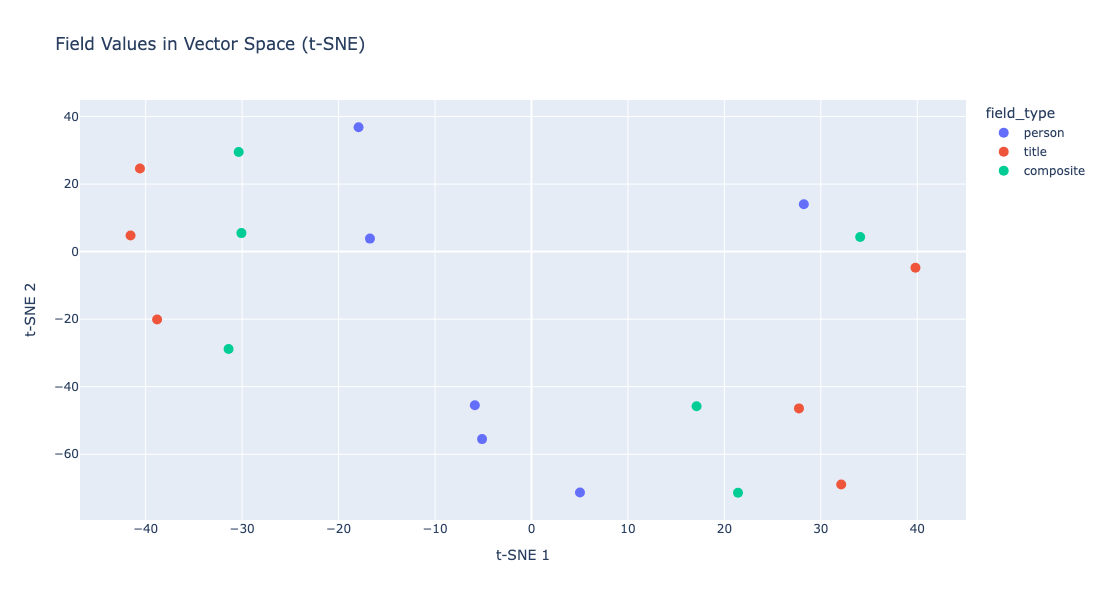

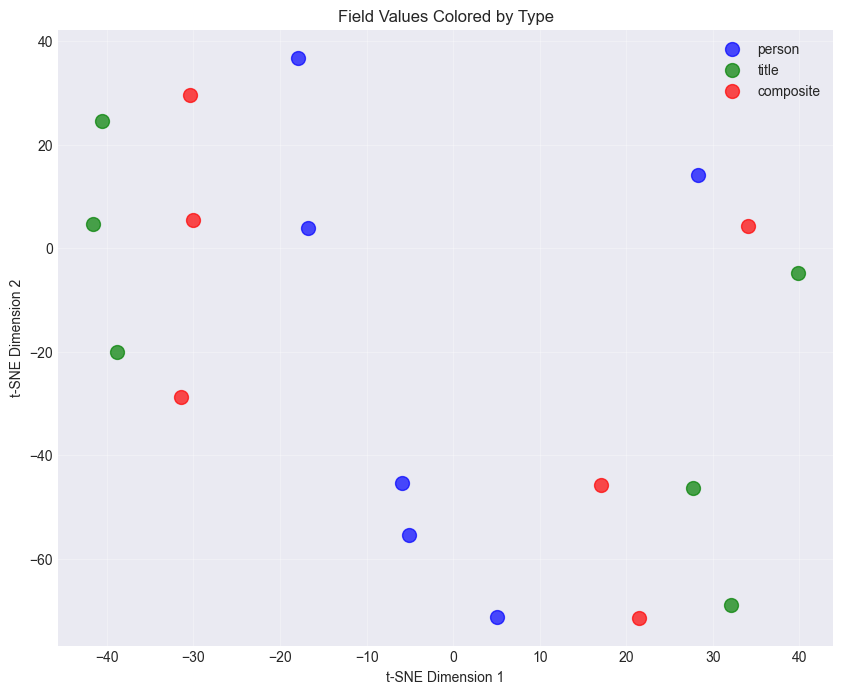

In [49]:
# t-SNE visualization colored by field type
print("Creating t-SNE visualization...")
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
vectors_2d = tsne.fit_transform(vectors)

# Create DataFrame for plotting
plot_df = pd.DataFrame({
    'x': vectors_2d[:, 0],
    'y': vectors_2d[:, 1],
    'label': labels,
    'field_type': field_types
})

# Create interactive plot
fig = px.scatter(plot_df, x='x', y='y', color='field_type',
                 hover_name='label',
                 title='Field Values in Vector Space (t-SNE)',
                 labels={'x': 't-SNE 1', 'y': 't-SNE 2'},
                 width=900, height=600)

fig.update_traces(marker=dict(size=10))
fig.show()

# Also create static plot
plt.figure(figsize=(10, 8))
colors = {'person': 'blue', 'title': 'green', 'composite': 'red'}
for field_type in colors:
    mask = plot_df['field_type'] == field_type
    plt.scatter(plot_df[mask]['x'], plot_df[mask]['y'], 
               c=colors[field_type], label=field_type, s=100, alpha=0.7)

plt.legend()
plt.title('Field Values Colored by Type')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True, alpha=0.3)
plt.show()

## 11. Cross-Field Similarity Analysis

Let's analyze how different field types relate to each other.

In [50]:
# Search across field types
archaeology_text = "archaeological photography documentation"
archaeology_embedding = get_embedding(archaeology_text)

print(f"Cross-field search for: '{archaeology_text}'\n")

# Search without field type filter
results = collection.query.near_vector(
    near_vector=archaeology_embedding.tolist(),
    limit=10,
    return_properties=["original_string", "field_type"],
    return_metadata=MetadataQuery(distance=True)
)

# Group by field type
by_field = {'person': [], 'title': [], 'composite': []}

for obj in results.objects:
    field_type = obj.properties['field_type']
    similarity = 1 - obj.metadata.distance
    by_field[field_type].append((obj.properties['original_string'][:50], similarity))

# Display grouped results
for field_type, matches in by_field.items():
    if matches:
        print(f"\n{field_type.upper()} matches:")
        for text, sim in matches[:3]:  # Top 3 per type
            print(f"  • {text}... (similarity: {sim:.3f})")

Cross-field search for: 'archaeological photography documentation'


PERSON matches:
  • Smith, Jennifer, 1975-... (similarity: 0.181)
  • Mello, Margarida, 1950-... (similarity: 0.166)
  • García Lorca, Federico, 1898-1936... (similarity: 0.130)

TITLE matches:
  • Digital Methods in Archaeological Documentation... (similarity: 0.674)
  • Archäologie und Photographie: fünfzig Beispiele zu... (similarity: 0.608)
  • Métodos computacionais em arqueologia brasileira... (similarity: 0.411)

COMPOSITE matches:
  • Contributor: Schubert, Franz August, 1805-1893
Tit... (similarity: 0.561)
  • Contributor: Smith, Jennifer, 1975-
Title: Digital... (similarity: 0.497)
  • Contributor: Mello, Margarida, 1950-
Title: Método... (similarity: 0.326)


## 12. Practical Entity Resolution Strategy

Combining multiple field similarities for better entity resolution.

In [51]:
# Compare all person pairs using multiple fields
def calculate_entity_similarity(id1: str, id2: str, weights: Dict[str, float] = None):
    """Calculate weighted similarity between two entities."""
    if weights is None:
        weights = {'person': 0.5, 'title': 0.2, 'composite': 0.3}
    
    similarities = {}
    total_score = 0
    
    for field, weight in weights.items():
        if field in hash_lookup[id1] and field in hash_lookup[id2]:
            hash1 = hash_lookup[id1][field]
            hash2 = hash_lookup[id2][field]
            
            vec1 = get_vector_by_hash(hash1, field)
            vec2 = get_vector_by_hash(hash2, field)
            
            if vec1 is not None and vec2 is not None:
                sim = cosine_similarity(vec1, vec2)
                similarities[field] = sim
                total_score += weight * sim
    
    return total_score, similarities

# Compare all entity pairs
print("Entity Resolution Analysis:\n")
entity_ids = [r['personId'] for r in catalog_records]

threshold = 0.7
potential_matches = []

for i in range(len(entity_ids)):
    for j in range(i+1, len(entity_ids)):
        id1, id2 = entity_ids[i], entity_ids[j]
        score, field_sims = calculate_entity_similarity(id1, id2)
        
        # Get person names for display
        person1 = next(r['person'] for r in catalog_records if r['personId'] == id1)
        person2 = next(r['person'] for r in catalog_records if r['personId'] == id2)
        
        if score > threshold:
            potential_matches.append((person1, person2, score, field_sims))
            print(f"Potential match found:")
            print(f"  {person1} ↔ {person2}")
            print(f"  Overall score: {score:.3f}")
            print(f"  Field similarities: {field_sims}")
            print()

if not potential_matches:
    print(f"No matches found above threshold {threshold}")

Entity Resolution Analysis:

No matches found above threshold 0.7


## 13. Key Takeaways

1. **Field-level indexing**: Each unique string value gets its own embedding
2. **Hash-based deduplication**: Ensures efficient storage of unique values
3. **Multi-field comparison**: Entity resolution benefits from comparing multiple fields
4. **Vector similarity challenges**: Name similarity alone can be misleading
5. **Weaviate efficiency**: Fast similarity search across thousands of field values

### Entity Resolution Best Practices:
- Use multiple fields with appropriate weights
- Consider field-specific similarity thresholds
- Combine vector similarity with other features (dates, roles, etc.)
- Monitor for false positives from similar names

In [52]:
# Clean up
weaviate_client.close()
print("✓ Closed Weaviate connection")

✓ Closed Weaviate connection
